Перенесем на сервер phf8.fa (самый длинный изоформ)

In [10]:
!ls /mnt/storage/project_2023/proteomes/*.faa

/mnt/storage/project_2023/proteomes/c.elegans.faa
/mnt/storage/project_2023/proteomes/ciliate.faa
/mnt/storage/project_2023/proteomes/drosophila.faa
/mnt/storage/project_2023/proteomes/e.coli.faa
/mnt/storage/project_2023/proteomes/human.faa
/mnt/storage/project_2023/proteomes/methanocaldococcus.faa
/mnt/storage/project_2023/proteomes/mouse.faa
/mnt/storage/project_2023/proteomes/thermococcus.faa
/mnt/storage/project_2023/proteomes/tuberculosis.faa
/mnt/storage/project_2023/proteomes/yeast.faa
/mnt/storage/project_2023/proteomes/zebrafish.faa


In [67]:
import subprocess
import glob
import os

path_calc = "/mnt/storage/project_2023/proteomes"
output_path = "/home/duzaripov/project"
input_files = sorted(glob.glob(f"{path_calc}/*.faa"))
output_files = [os.path.splitext(os.path.basename(file))[0] for file in input_files]

def run_blastp(input, output):
    cmd = f"blastp -query phf8.fa -db {input} -out PHF8_{output}.blast -outfmt 7"
    subprocess.run(cmd, shell=True, stdout=subprocess.DEVNULL)

for input, output in zip(input_files, output_files):
    run_blastp(input, output)

Перенесем в папку проекта один белок из каждого гистона (H2A_single.fasta, H2B_single.fasta, ...)

In [2]:
import subprocess
import glob
import os

path1 = "/home/duzaripov/project/"
path2 = "/mnt/storage/project_2023/proteomes"
input_files1 = sorted(glob.glob(f"{path1}/*single.fasta"))
input_files2 = sorted(glob.glob(f"{path2}/*.faa"))

def run_blastp(input1, input2):
    output_path = "/home/duzaripov/project"
    histone_name = os.path.basename(input1).replace("_single.fasta", "")
    proteome_name = os.path.basename(input2).replace(".faa", "")
    output = os.path.join(output_path, f"{histone_name}_{proteome_name}")
    cmd = f"blastp -query {input1} -db {input2} -out {output}.blast -outfmt 7"
    subprocess.run(cmd, shell=True, stdout=subprocess.DEVNULL)

for input1 in input_files1:
    for input2 in input_files2:
        run_blastp(input1, input2)

In [2]:
import os
import pandas as pd
import glob

def parse_blast_files(directory):
    blast_files = [file for file in os.listdir(directory) if file.endswith('.blast')]

    path1 = "/mnt/storage/project_2023/histones"
    path2 = "/mnt/storage/project_2023/proteomes"
    input_files1 = sorted(glob.glob(f"{path1}/*.fasta"))
    input_files2 = sorted(glob.glob(f"{path2}/*.faa"))

    histones = [os.path.splitext(os.path.basename(file))[0] for file in input_files1]
    histones.append('PHF8')
    # proteomes = [os.path.splitext(os.path.basename(file))[0] for file in input_files2]
    proteomes = ['human','mouse','zebrafish','drosophila','c.elegans',
                 'ciliate','yeast','methanocaldococcus','thermococcus','e.coli','tuberculosis']

    data = []
    for file in blast_files:
        file_path = os.path.join(directory, file)
        with open(file_path, 'r') as f:
            lines = f.readlines()
        
        first_evalue = lines[5].split('\t')[10].strip()
        if float(first_evalue) > 1:
            first_evalue = '1'
        elif float(first_evalue) < 1e-300:
            first_evalue = '1e-300'
        data.append((os.path.splitext(file)[0], first_evalue))
    
    df = pd.DataFrame(data, columns=['Histone_proteome', 'Evalue'])

    result_df = pd.DataFrame(index=histones, columns=proteomes)

    for row in df.itertuples(index=False):
        proteome = row.Histone_proteome.split('_')[1]
        histone = row.Histone_proteome.split('_', 1)[0]
        result_df.at[histone, proteome] = row.Evalue

    result_df.to_csv('blast_results.csv')
    return result_df

directory_path = "/home/duzaripov/project/"
result_df = parse_blast_files(directory_path)

In [9]:
result_df

,human,mouse,zebrafish,drosophila,c.elegans,ciliate,yeast,methanocaldococcus,thermococcus,e.coli,tuberculosis
H2A,4.94e-91,4.57e-84,1.06e-81,2.34e-69,6.53e-67,2.45e-57,8.88e-63,0.001,0.15,1,0.40
H2B,2.85e-87,1.15e-83,1.85e-71,3.30e-59,5.28e-65,1.91e-49,3.07e-57,1,0.17,1,1
H3,2.19e-96,1.54e-96,1.77e-95,9.39e-96,4.46e-94,8.41e-86,3.31e-87,0.034,0.057,0.90,1
H4,1.09e-67,7.60e-68,1.13e-68,8.02e-68,6.15e-68,1.96e-45,1.08e-52,8.22e-05,3.31e-05,1,0.069
PHF8,1e-300,1e-300,1e-300,8.60e-83,1.91e-74,3.98e-09,7.77e-49,0.96,0.68,1,1


In [10]:
import numpy as np
def df_to_log(result_df):
    log_df = result_df.copy()
    log_df = np.abs(np.log10(log_df.apply(pd.to_numeric)))
    return log_df

log_df = df_to_log(result_df)
log_df.to_csv('blast_results_log.csv')
log_df

,human,mouse,zebrafish,drosophila,c.elegans,ciliate,yeast,methanocaldococcus,thermococcus,e.coli,tuberculosis
H2A,90.306273,83.340084,80.974694,68.630784,66.185087,56.610834,62.051587,3.000000,0.823909,0.000000,0.397940
H2B,86.545155,82.939302,70.732828,58.481486,64.277366,48.718967,56.512862,0.000000,0.769551,0.000000,0.000000
H3,95.659556,95.812479,94.752027,95.027334,93.350665,85.075204,86.480172,1.468521,1.244125,0.045757,0.000000
H4,66.962574,67.119186,67.946922,67.095826,67.211125,44.707744,51.966576,4.085128,4.480172,0.000000,1.161151
PHF8,300.000000,300.000000,300.000000,82.065502,73.718967,8.400117,48.109579,0.017729,0.167491,0.000000,0.000000


<Axes: >

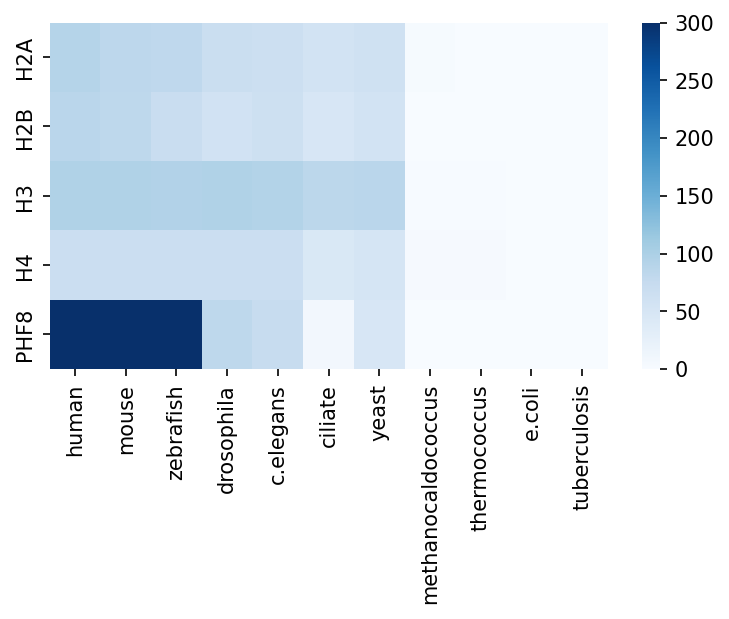

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 3), dpi=150)
sns.heatmap(log_df, cmap='Blues')

In [11]:
data = []
directory_path = "/home/duzaripov/project/"
blast_files = [file for file in os.listdir(directory_path) if file.endswith('.blast')]
print('Количество хитов')
for file in blast_files:
    if file.startswith("PHF8_"):
        file_path = os.path.join(directory_path, file)
        with open(file_path, 'r') as f:
            lines = f.readlines()
        
        hits_found = lines[4].split(' ')[1]
        print(file, hits_found)

Количество хитов
PHF8_methanocaldococcus.blast 3
PHF8_ciliate.blast 11
PHF8_e.coli.blast 3
PHF8_human.blast 319
PHF8_mouse.blast 266
PHF8_c.elegans.blast 69
PHF8_tuberculosis.blast 8
PHF8_yeast.blast 19
PHF8_zebrafish.blast 142
PHF8_drosophila.blast 74
PHF8_thermococcus.blast 6
